In [1]:
import datetime

import pandas as pd
import numpy as np
import os
##import pandas_profiling

from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
import math
import mlflow.sklearn
from azureml.core import Workspace
import urllib.request
import json
import os
import ssl


#Easier way of standardizing the data since we're working with larger components
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn import model_selection, preprocessing
from sklearn import metrics


#All the azure stuff
import mlflow
from mlflow.azureml import deploy

from azureml.core import Workspace
from mlflow.tracking.artifact_utils import _download_artifact_from_uri
from azureml.core.webservice import AciWebservice, Webservice
import azure.core

import matplotlib.pyplot as plt

In [2]:
os.listdir('./')

['.ipynb_checkpoints',
 'BTC-Time-Series-Model.ipynb',
 'btc-usdt.csv',
 'config.json',
 'finalProject.ipynb',
 'FinalProjectV2.ipynb',
 'lstm.ipynb',
 'Main.ipynb',
 'newTest - Copy.ipynb',
 'newTest.ipynb',
 'origRNN.ipynb',
 'starter.ipynb',
 'Test.ipynb']

In [3]:
baseDataFrame = pd.read_csv("btc-usdt.csv")
baseDataFrame.head()

,Open Time,Open,High,Low,Close,Volume,Close Time,Quote Asset Volume,Number of Trades,TB Base Volume,TB Quote Volume,Ignore
0,2019-07-30 00:00:00.000000000,9509.07,9535.00,9503.07,9517.75,381.293856,2019-07-30 00:29:59.999000064,3.631211e+06,3492,216.528742,2.062189e+06,0
1,2019-07-30 00:30:00.000000000,9517.03,9539.00,9507.00,9532.58,258.514869,2019-07-30 00:59:59.999000064,2.462134e+06,3133,141.887550,1.351182e+06,0
2,2019-07-30 01:00:00.000000000,9533.59,9534.00,9500.00,9500.25,275.797270,2019-07-30 01:29:59.999000064,2.624322e+06,3583,114.238457,1.087402e+06,0
3,2019-07-30 01:30:00.000000000,9500.25,9514.46,9460.71,9465.25,485.218470,2019-07-30 01:59:59.999000064,4.604004e+06,5330,225.681291,2.141459e+06,0
4,2019-07-30 02:00:00.000000000,9465.25,9488.94,9430.01,9460.42,498.669626,2019-07-30 02:29:59.999000064,4.717269e+06,6197,228.535910,2.162163e+06,0


In [4]:
type(baseDataFrame["Open Time"])

pandas.core.series.Series

In [5]:
#Change the open tim to a simpler open date
newDF = pd.DataFrame(baseDataFrame)
newDF["Open Time"] = pd.to_datetime(newDF["Open Time"])
newDF["Open Time"] = newDF["Open Time"].dt.date
baseDataFrame.dtypes

Open Time              object
Open                  float64
High                  float64
Low                   float64
Close                 float64
Volume                float64
Close Time             object
Quote Asset Volume    float64
Number of Trades        int64
TB Base Volume        float64
TB Quote Volume       float64
Ignore                  int64
dtype: object

In [6]:
newDF["Open Time"] = pd.to_datetime(newDF["Open Time"])
baseDataFrame.dtypes

Open Time             datetime64[ns]
Open                         float64
High                         float64
Low                          float64
Close                        float64
Volume                       float64
Close Time                    object
Quote Asset Volume           float64
Number of Trades               int64
TB Base Volume               float64
TB Quote Volume              float64
Ignore                         int64
dtype: object

In [7]:
newDF.head()

,Open Time,Open,High,Low,Close,Volume,Close Time,Quote Asset Volume,Number of Trades,TB Base Volume,TB Quote Volume,Ignore
0,2019-07-30,9509.07,9535.00,9503.07,9517.75,381.293856,2019-07-30 00:29:59.999000064,3.631211e+06,3492,216.528742,2.062189e+06,0
1,2019-07-30,9517.03,9539.00,9507.00,9532.58,258.514869,2019-07-30 00:59:59.999000064,2.462134e+06,3133,141.887550,1.351182e+06,0
2,2019-07-30,9533.59,9534.00,9500.00,9500.25,275.797270,2019-07-30 01:29:59.999000064,2.624322e+06,3583,114.238457,1.087402e+06,0
3,2019-07-30,9500.25,9514.46,9460.71,9465.25,485.218470,2019-07-30 01:59:59.999000064,4.604004e+06,5330,225.681291,2.141459e+06,0
4,2019-07-30,9465.25,9488.94,9430.01,9460.42,498.669626,2019-07-30 02:29:59.999000064,4.717269e+06,6197,228.535910,2.162163e+06,0


In [8]:
newDF = newDF.drop(["Close Time", "Ignore"], axis = 1)
newDF.head()

,Open Time,Open,High,Low,Close,Volume,Quote Asset Volume,Number of Trades,TB Base Volume,TB Quote Volume
0,2019-07-30,9509.07,9535.00,9503.07,9517.75,381.293856,3.631211e+06,3492,216.528742,2.062189e+06
1,2019-07-30,9517.03,9539.00,9507.00,9532.58,258.514869,2.462134e+06,3133,141.887550,1.351182e+06
2,2019-07-30,9533.59,9534.00,9500.00,9500.25,275.797270,2.624322e+06,3583,114.238457,1.087402e+06
3,2019-07-30,9500.25,9514.46,9460.71,9465.25,485.218470,4.604004e+06,5330,225.681291,2.141459e+06
4,2019-07-30,9465.25,9488.94,9430.01,9460.42,498.669626,4.717269e+06,6197,228.535910,2.162163e+06


In [9]:
#finding out what the gain is on each day
newDF["yesterdayGain"] = newDF["Close"].shift(1)
newDF["tomorrowGain"] =  newDF["Close"].shift(-1) - newDF["Close"]
#Needs this to account for the afterhours markets
newDF["tomorrowOpen"] = newDF["Open"].shift(-1)

In [10]:
newDF.head()

,Open Time,Open,High,Low,Close,Volume,Quote Asset Volume,Number of Trades,TB Base Volume,TB Quote Volume,yesterdayGain,tomorrowGain,tomorrowOpen
0,2019-07-30,9509.07,9535.00,9503.07,9517.75,381.293856,3.631211e+06,3492,216.528742,2.062189e+06,NaN,14.83,9517.03
1,2019-07-30,9517.03,9539.00,9507.00,9532.58,258.514869,2.462134e+06,3133,141.887550,1.351182e+06,9517.75,-32.33,9533.59
2,2019-07-30,9533.59,9534.00,9500.00,9500.25,275.797270,2.624322e+06,3583,114.238457,1.087402e+06,9532.58,-35.00,9500.25
3,2019-07-30,9500.25,9514.46,9460.71,9465.25,485.218470,4.604004e+06,5330,225.681291,2.141459e+06,9500.25,-4.83,9465.25
4,2019-07-30,9465.25,9488.94,9430.01,9460.42,498.669626,4.717269e+06,6197,228.535910,2.162163e+06,9465.25,-34.87,9461.73


In [11]:
newDF = newDF.dropna(axis=0)
newDF.head()

,Open Time,Open,High,Low,Close,Volume,Quote Asset Volume,Number of Trades,TB Base Volume,TB Quote Volume,yesterdayGain,tomorrowGain,tomorrowOpen
1,2019-07-30,9517.03,9539.00,9507.00,9532.58,258.514869,2.462134e+06,3133,141.887550,1.351182e+06,9517.75,-32.33,9533.59
2,2019-07-30,9533.59,9534.00,9500.00,9500.25,275.797270,2.624322e+06,3583,114.238457,1.087402e+06,9532.58,-35.00,9500.25
3,2019-07-30,9500.25,9514.46,9460.71,9465.25,485.218470,4.604004e+06,5330,225.681291,2.141459e+06,9500.25,-4.83,9465.25
4,2019-07-30,9465.25,9488.94,9430.01,9460.42,498.669626,4.717269e+06,6197,228.535910,2.162163e+06,9465.25,-34.87,9461.73
5,2019-07-30,9461.73,9470.46,9402.00,9425.55,1877.784054,1.773400e+07,9726,344.451758,3.250685e+06,9460.42,5.90,9425.60


In [12]:
learningDF = newDF.copy()

In [13]:
learningDF.head()

,Open Time,Open,High,Low,Close,Volume,Quote Asset Volume,Number of Trades,TB Base Volume,TB Quote Volume,yesterdayGain,tomorrowGain,tomorrowOpen
1,2019-07-30,9517.03,9539.00,9507.00,9532.58,258.514869,2.462134e+06,3133,141.887550,1.351182e+06,9517.75,-32.33,9533.59
2,2019-07-30,9533.59,9534.00,9500.00,9500.25,275.797270,2.624322e+06,3583,114.238457,1.087402e+06,9532.58,-35.00,9500.25
3,2019-07-30,9500.25,9514.46,9460.71,9465.25,485.218470,4.604004e+06,5330,225.681291,2.141459e+06,9500.25,-4.83,9465.25
4,2019-07-30,9465.25,9488.94,9430.01,9460.42,498.669626,4.717269e+06,6197,228.535910,2.162163e+06,9465.25,-34.87,9461.73
5,2019-07-30,9461.73,9470.46,9402.00,9425.55,1877.784054,1.773400e+07,9726,344.451758,3.250685e+06,9460.42,5.90,9425.60


In [14]:
learningDF.head()

,Open Time,Open,High,Low,Close,Volume,Quote Asset Volume,Number of Trades,TB Base Volume,TB Quote Volume,yesterdayGain,tomorrowGain,tomorrowOpen
1,2019-07-30,9517.03,9539.00,9507.00,9532.58,258.514869,2.462134e+06,3133,141.887550,1.351182e+06,9517.75,-32.33,9533.59
2,2019-07-30,9533.59,9534.00,9500.00,9500.25,275.797270,2.624322e+06,3583,114.238457,1.087402e+06,9532.58,-35.00,9500.25
3,2019-07-30,9500.25,9514.46,9460.71,9465.25,485.218470,4.604004e+06,5330,225.681291,2.141459e+06,9500.25,-4.83,9465.25
4,2019-07-30,9465.25,9488.94,9430.01,9460.42,498.669626,4.717269e+06,6197,228.535910,2.162163e+06,9465.25,-34.87,9461.73
5,2019-07-30,9461.73,9470.46,9402.00,9425.55,1877.784054,1.773400e+07,9726,344.451758,3.250685e+06,9460.42,5.90,9425.60


In [15]:
xBase = learningDF["Open"].copy()
yBase = learningDF["tomorrowOpen"].copy()

In [16]:
xTRain, xTest, yTrain, yTest = model_selection.train_test_split(xBase, yBase, test_size =.25)

In [17]:
xTRain.head()

18583    11849.02
31522    44955.35
25816    36468.31
35795    45862.84
25022    31290.53
Name: Open, dtype: float64

In [18]:
xTest.head()

27560    50738.27
8929      9336.17
22723    15953.73
7602      7340.90
44673    43598.62
Name: Open, dtype: float64

In [19]:
modelSequential = Sequential()
modelSequential.add(layers.Dense(8, input_dim=1, activation='relu'))
modelSequential.add(layers.Dense(1))
modelSequential.compile(loss='mean_squared_error', optimizer='adam')
modelSequential.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 8)                 16        
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 25
Trainable params: 25
Non-trainable params: 0
_________________________________________________________________


In [4]:
#Commented out to not accidentally redo model in azure
#ws = Workspace.from_config(_file_name='config.json')
#mlflow.set_tracking_uri(azFlowWorkspace.get_mlflow_tracking_uri())

In [20]:
#mlflow.set_experiment('finalSequential')
#mlflow.tensorflow.autolog(every_n_iter=1)

2022/05/14 19:44:25 INFO mlflow.tracking.fluent: Experiment with name 'finalSequential' does not exist. Creating a new experiment.


In [21]:
modelSequential.fit(xTRain, yTrain, epochs=200, batch_size=2, verbose=1)

2022/05/14 19:44:27 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '67f14752-8d9f-4fa3-b20b-352f5b560f75', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current tensorflow workflow


Epoch 1/200
18245/18245 [==============================] - 10s 555us/step - loss: 7627262.5000
Epoch 2/200
18245/18245 [==============================] - 9s 496us/step - loss: 54348.3281
Epoch 3/200
18245/18245 [==============================] - 10s 542us/step - loss: 53520.2656
Epoch 4/200
18245/18245 [==============================] - 10s 552us/step - loss: 52364.7852
Epoch 5/200
18245/18245 [==============================] - 10s 559us/step - loss: 52990.6992
Epoch 6/200
18245/18245 [==============================] - 10s 558us/step - loss: 52661.2383
Epoch 7/200
18245/18245 [==============================] - 10s 545us/step - loss: 52501.5352
Epoch 8/200
18245/18245 [==============================] - 10s 533us/step - loss: 52354.1289
Epoch 9/200
18245/18245 [==============================] - 9s 521us/step - loss: 51174.2461
Epoch 10/200
18245/18245 [==============================] - 10s 527us/step - loss: 50074.4180
Epoch 11/200
18245/18245 [==============================] - 10s 540us

18245/18245 [==============================] - 10s 530us/step - loss: 44324.8516
Epoch 172/200
18245/18245 [==============================] - 9s 517us/step - loss: 44628.8555
Epoch 173/200
18245/18245 [==============================] - 10s 522us/step - loss: 44152.8477
Epoch 174/200
18245/18245 [==============================] - 10s 544us/step - loss: 44593.9023
Epoch 175/200
18245/18245 [==============================] - 16s 868us/step - loss: 44346.2031
Epoch 176/200
18245/18245 [==============================] - 9s 512us/step - loss: 44510.2383
Epoch 177/200
18245/18245 [==============================] - 9s 521us/step - loss: 44543.0469
Epoch 178/200
18245/18245 [==============================] - 10s 572us/step - loss: 44819.5391
Epoch 179/200
18245/18245 [==============================] - 10s 566us/step - loss: 44407.3711
Epoch 180/200
18245/18245 [==============================] - 10s 534us/step - loss: 44740.5781
Epoch 181/200
18245/18245 [==============================] - 10s 53

In [22]:
# Estimate model performance
trainScore = modelSequential.evaluate(xTRain, yTrain, verbose=0)
print('Train Score: %.2f MSE (%.2f RMSE)' % (trainScore, math.sqrt(trainScore)))
testScore = modelSequential.evaluate(xTest, yTest, verbose=0)
print('Test Score: %.2f MSE (%.2f RMSE)' % (testScore, math.sqrt(testScore)))

Train Score: 40750.51 MSE (201.87 RMSE)
Test Score: 40078.95 MSE (200.20 RMSE)


In [23]:
modelSequential.predict(yTrain)

array([[11856.49 ],
       [45235.094],
       [36586.58 ],
       ...,
       [ 9297.213],
       [34442.99 ],
       [ 6208.981]], dtype=float32)

In [24]:
type(yTest)

pandas.core.series.Series

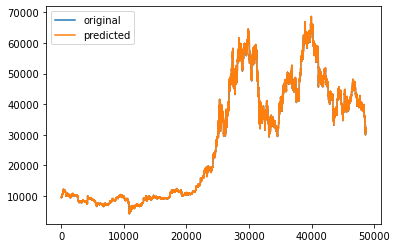

In [25]:
plt.plot(learningDF["tomorrowOpen"], label='original')
plt.plot(modelSequential.predict(learningDF["Open"]), label='predicted')
plt.legend()
plt.show()

In [26]:
#mlflow.tensorflow.autolog(disable=True)

## Not great accuracy, what other way to do this?

In [27]:
# Set a fixed random seed to improve reproducibility
np.random.seed(7)

In [28]:
#make the scalers and the data
x_scaler = MinMaxScaler(feature_range=(-1, 1))
y_scaler = MinMaxScaler(feature_range=(-1, 1))
x = learningDF['Open'].copy()
y = learningDF['tomorrowOpen'].copy()

In [29]:
xBase = x_scaler.fit_transform(x.values.reshape(-1, 1))
yBase = y_scaler.fit_transform(y.values.reshape(-1, 1))

In [30]:
xTRain, xTest, yTrain, yTest = model_selection.train_test_split(xBase, yBase, test_size =.25)

In [32]:

print(xTRain.shape, yTrain.shape, xTest.shape, yTest.shape)
print (xTRain[0], yTrain[0])

(36489, 1) (36489, 1) (12164, 1) (12164, 1)
[0.35442188] [0.35829359]


In [33]:
modelLTSM = Sequential()
modelLTSM.add(layers.LSTM(4, input_shape=(1, 1)))
modelLTSM.add(layers.Dense(1))
modelLTSM.compile(loss='mean_squared_error', optimizer='adam')

In [35]:
modelLTSM.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 4)                 96        
                                                                 
 dense_2 (Dense)             (None, 1)                 5         
                                                                 
Total params: 101
Trainable params: 101
Non-trainable params: 0
_________________________________________________________________


In [37]:
#mlflow.set_experiment('finalLTSM')
#mlflow.tensorflow.autolog(disable = False, every_n_iter=1)

In [38]:
modelLTSM.fit(xTRain, yTrain, epochs=100, batch_size=1, verbose=1)

2022/05/15 11:01:01 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '345a5113-6a45-44ee-b0c9-4af15d2920cf', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current tensorflow workflow


Epoch 1/100
36489/36489 [==============================] - 32s 857us/step - loss: 0.0042
Epoch 2/100
36489/36489 [==============================] - 31s 852us/step - loss: 5.3067e-05
Epoch 3/100
36489/36489 [==============================] - 31s 851us/step - loss: 5.3152e-05
Epoch 4/100
36489/36489 [==============================] - 33s 896us/step - loss: 5.3123e-05
Epoch 5/100
36489/36489 [==============================] - 32s 878us/step - loss: 5.2585e-05
Epoch 6/100
36489/36489 [==============================] - 31s 849us/step - loss: 5.2095e-05
Epoch 7/100
36489/36489 [==============================] - 31s 848us/step - loss: 5.2266e-05
Epoch 8/100
36489/36489 [==============================] - 31s 844us/step - loss: 5.1641e-05
Epoch 9/100
36489/36489 [==============================] - 33s 911us/step - loss: 5.1587e-05
Epoch 10/100
36489/36489 [==============================] - 31s 852us/step - loss: 5.1229e-05
Epoch 11/100
36489/36489 [==============================] - 31s 838us/ste

INFO:tensorflow:Assets written to: C:\Users\Martynow\AppData\Local\Temp\tmpuxfd5xo5\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\Martynow\AppData\Local\Temp\tmpuxfd5xo5\model\data\model\assets


In [39]:
trainScore = modelLTSM.evaluate(xTRain, yTrain, verbose=0)
print('Train Score: %.2f MSE (%.2f RMSE)' % (trainScore, math.sqrt(trainScore)))
testScore = modelLTSM.evaluate(xTest, yTest, verbose=0)
print('Test Score: %.2f MSE (%.2f RMSE)' % (testScore, math.sqrt(testScore)))

Train Score: 0.00 MSE (0.01 RMSE)
Test Score: 0.00 MSE (0.01 RMSE)


In [40]:
#mlflow.tensorflow.autolog(disable = True)

In [41]:
xTRain

array([[ 0.35442188],
       [-0.80954203],
       [ 0.39113998],
       ...,
       [-0.80585078],
       [ 0.57964644],
       [-0.88729176]])

In [42]:
learningDF["Open"].head()

1    9517.03
2    9533.59
3    9500.25
4    9465.25
5    9461.73
Name: Open, dtype: float64

In [43]:
dataSet = learningDF["Open"].values
dataSet = dataSet.astype('float32')
train_size = int(len(dataSet) * 0.67)

In [44]:
scaler = MinMaxScaler(feature_range=(-1, 1))
dataSet = scaler.fit_transform(dataSet.reshape(-1,1))

In [45]:
test_size = len(dataSet) - train_size
train, test = dataSet[0:train_size,:], dataSet[train_size:len(dataSet),:]
print(len(train), len(test))

32597 16056


In [46]:
# convert an array of values into a dataset matrix because the shift method used before was messing up the MSE hard
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

In [47]:
# reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [48]:
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [49]:
#mlflow.set_experiment('finalLTSMScaled')
#mlflow.tensorflow.autolog(disable = False, every_n_iter=1)

2022/05/15 11:54:08 INFO mlflow.tracking.fluent: Experiment with name 'finalLTSMScaled' does not exist. Creating a new experiment.


In [50]:
modelLTSMScaled = Sequential()
modelLTSMScaled.add(layers.LSTM(4, input_shape=(1, 1)))
modelLTSMScaled.add(layers.Dense(1))
modelLTSMScaled.compile(loss='mean_squared_error', optimizer='adam')

In [51]:
modelLTSMScaled.fit(trainX, trainY, epochs=100, batch_size=1, verbose=1)

2022/05/15 11:54:09 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'd9b88dee-6429-4c45-8aed-a06fa4bb703d', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current tensorflow workflow


Epoch 1/100
    1/32595 [..............................] - ETA: 7:26:38 - loss: 0.6550WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0010s vs `on_train_batch_end` time: 0.0065s). Check your callbacks.


32595/32595 [==============================] - 29s 878us/step - loss: 0.0039
Epoch 2/100
32595/32595 [==============================] - 28s 859us/step - loss: 8.1686e-05
Epoch 3/100
32595/32595 [==============================] - 28s 869us/step - loss: 6.4228e-05
Epoch 4/100
32595/32595 [==============================] - 28s 854us/step - loss: 5.1221e-05
Epoch 5/100
32595/32595 [==============================] - 34s 1ms/step - loss: 4.8129e-05
Epoch 6/100
32595/32595 [==============================] - 28s 855us/step - loss: 4.6333e-05
Epoch 7/100
32595/32595 [==============================] - 28s 851us/step - loss: 4.5993e-05
Epoch 8/100
32595/32595 [==============================] - 34s 1ms/step - loss: 4.5564e-05
Epoch 9/100
32595/32595 [==============================] - 28s 860us/step - loss: 4.5612e-05
Epoch 10/100
32595/32595 [==============================] - 28s 858us/step - loss: 4.4610e-05
Epoch 11/100
32595/32595 [==============================] - 28s 856us/step - loss: 4.3679

INFO:tensorflow:Assets written to: C:\Users\Martynow\AppData\Local\Temp\tmpe53ljkqj\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\Martynow\AppData\Local\Temp\tmpe53ljkqj\model\data\model\assets


In [53]:
trainScore = modelLTSMScaled.evaluate(xTRain, yTrain, verbose=0)
print('Train Score: %.2f MSE (%.2f RMSE)' % (trainScore, math.sqrt(trainScore)))
testScore = modelLTSMScaled.evaluate(xTest, yTest, verbose=0)
print('Test Score: %.2f MSE (%.2f RMSE)' % (testScore, math.sqrt(testScore)))

Train Score: 0.00 MSE (0.01 RMSE)
Test Score: 0.00 MSE (0.01 RMSE)


In [54]:
#mlflow.tensorflow.autolog(disable = True, every_n_iter=1)

In [5]:
experiment_name = 'finalSequential'

# gets the list of runs for your experiment as an array
exp = ws.experiments[experiment_name]
runs = list(exp.get_runs())
print(runs)

[Run(Experiment: finalSequential,
Id: 67f14752-8d9f-4fa3-b20b-352f5b560f75,
Type: None,
Status: Completed)]


In [6]:
runid = runs[-1].id
print(runid)

67f14752-8d9f-4fa3-b20b-352f5b560f75


In [7]:
model_path = 'model'

model_uri='runs:/{}/{}'.format(runid, model_path)

In [9]:
#config information from model stored in azure, direct Azure to Azure pipeline
aci_config = AciWebservice.deploy_configuration(cpu_cores=1, 
                                                memory_gb=1, 
                                                tags={'method' : 'keras'}, 
                                                description='finalsequential',
                                                location='eastus')

In [10]:
#deploying the model
(webservice,model) = mlflow.azureml.deploy( model_uri='runs:/{}/{}'.format(runid, model_path),
                      workspace=ws,
                      model_name='finalsequentialmodel', 
                      service_name='finasequential-model-1', 
                      deployment_config=aci_config, 
                      tags=None, mlflow_home=None, synchronous=True)

webservice.wait_for_deployment(show_output=True)

C:\Users\Martynow\AppData\Local\Temp/ipykernel_19608/572064898.py:2: DeprecationWarning: ``mlflow.azureml.deploy`` is deprecated since 1.19.0. This method will be removed in a near future release. Use ``the azureml deployment plugin, https://aka.ms/aml-mlflow-deploy`` instead.
  (webservice,model) = mlflow.azureml.deploy( model_uri='runs:/{}/{}'.format(runid, model_path),
Successfully registered model 'finalsequentialmodel'.
2022/05/15 13:36:46 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: finalsequentialmodel, version 1
Created version '1' of model 'finalsequentialmodel'.
2022/05/15 13:36:46 INFO mlflow.azureml: Registered an Azure Model with name: `finalsequentialmodel` and version: `finalsequentialmodel:1`
2022/05/15 13:36:47 INFO mlflow.azureml: Found registered model in AzureML with ID 'finalsequentialmodel:1'
2022/05/15 13:36:57 INFO mlflow.azureml: Deploying an Azure Webservice with na

Tips: You can try get_logs(): https://aka.ms/debugimage#dockerlog or local deployment: https://aka.ms/debugimage#debug-locally to debug if deployment takes longer than 10 minutes.
Running
2022-05-15 13:36:51-05:00 Creating Container Registry if not exists.
2022-05-15 13:36:52-05:00 Registering the environment.
2022-05-15 13:36:53-05:00 Building image..
2022-05-15 13:42:50-05:00 Generating deployment configuration.
2022-05-15 13:42:51-05:00 Submitting deployment to compute..
2022-05-15 13:42:55-05:00 Checking the status of deployment finasequential-model-1..
2022-05-15 13:46:10-05:00 Checking the status of inference endpoint finasequential-model-1.
Succeeded
ACI service creation operation finished, operation "Succeeded"
Tips: You can try get_logs(): https://aka.ms/debugimage#dockerlog or local deployment: https://aka.ms/debugimage#debug-locally to debug if deployment takes longer than 10 minutes.
SucceededACI service creation operation finished, operation "Succeeded"


In [204]:
# URL for the model
scoring_uri = 'http://6dedce89-03cb-4eec-9809-cf915d6e00c4.eastus.azurecontainer.io/score'


# Set the content type
#headers = {'Content-Type': 'application/json; format=pandas-split'}
headers = {'Content-Type':'application/json'}


In [22]:
import requests

In [38]:
startDate = '2022-03-31'
endDate = '2022-05-01'

In [39]:
#getting the price of bitcoin for the month of April. With the last day of March to help feed tomorrow dates.
response = requests.get('https://api.coindesk.com/v1/bpi/historical/close.json?start='+startDate+'&end='+endDate )

In [40]:
response.text

'{"bpi":{"2022-03-31":46318.5625,"2022-04-01":46154.5,"2022-04-02":46321.275,"2022-04-03":46571.355,"2022-04-04":45701.5475,"2022-04-05":45809.58,"2022-04-06":44106.255,"2022-04-07":43600,"2022-04-08":43090.215,"2022-04-09":42459.5,"2022-04-10":42726,"2022-04-11":40865.25,"2022-04-12":40617.5,"2022-04-13":39888.5,"2022-04-14":41023.5,"2022-04-15":40310.5,"2022-04-16":40411.5,"2022-04-17":40339.5,"2022-04-18":39036.355,"2022-04-19":40661.67,"2022-04-20":41440,"2022-04-21":41931,"2022-04-22":39494.5,"2022-04-23":39732.605,"2022-04-24":39605.645,"2022-04-25":39111.5,"2022-04-26":39971.98,"2022-04-27":39043.5,"2022-04-28":39627.555,"2022-04-29":39158.385,"2022-04-30":38617,"2022-05-01":37923.8125},"disclaimer":"This data was produced from the CoinDesk Bitcoin Price Index. BPI value data returned as USD.","time":{"updated":"May 2, 2022 00:03:00 UTC","updatedISO":"2022-05-02T00:03:00+00:00"}}'

In [41]:
btcPrices = response.json()

In [42]:
aprilDF = pd.DataFrame().from_dict(btcPrices)

In [43]:
aprilDF.head()

,bpi,disclaimer,time
2022-03-31,46318.5625,This data was produced from the CoinDesk Bitco...,NaN
2022-04-01,46154.5000,This data was produced from the CoinDesk Bitco...,NaN
2022-04-02,46321.2750,This data was produced from the CoinDesk Bitco...,NaN
2022-04-03,46571.3550,This data was produced from the CoinDesk Bitco...,NaN
2022-04-04,45701.5475,This data was produced from the CoinDesk Bitco...,NaN


In [44]:
aprilDF = aprilDF.drop(["disclaimer", "time"], axis = 1)

In [45]:
aprilDF.head()

,bpi
2022-03-31,46318.5625
2022-04-01,46154.5000
2022-04-02,46321.2750
2022-04-03,46571.3550
2022-04-04,45701.5475


In [46]:
aprilDF["tomorrowOpen"] = aprilDF["bpi"].shift(-1)

In [47]:
aprilDF.head()

,bpi,tomorrowOpen
2022-03-31,46318.5625,46154.5000
2022-04-01,46154.5000,46321.2750
2022-04-02,46321.2750,46571.3550
2022-04-03,46571.3550,45701.5475
2022-04-04,45701.5475,45809.5800


In [48]:
aprilDF.tail()

,bpi,tomorrowOpen
2022-04-29,39158.3850,38617.0000
2022-04-30,38617.0000,37923.8125
2022-05-01,37923.8125,NaN
updated,NaN,NaN
updatedISO,NaN,NaN


In [50]:
aprilDF = aprilDF.dropna(axis=0)

In [65]:
aprilDF.iloc[0].to_json(orient='split')

'{"name":"2022-03-31","index":["bpi","tomorrowOpen"],"data":[46318.5625,46154.5]}'

In [98]:
aprilDF["bpi"].to_json(orient='split')

'{"name":"bpi","index":["2022-03-31","2022-04-01","2022-04-02","2022-04-03","2022-04-04","2022-04-05","2022-04-06","2022-04-07","2022-04-08","2022-04-09","2022-04-10","2022-04-11","2022-04-12","2022-04-13","2022-04-14","2022-04-15","2022-04-16","2022-04-17","2022-04-18","2022-04-19","2022-04-20","2022-04-21","2022-04-22","2022-04-23","2022-04-24","2022-04-25","2022-04-26","2022-04-27","2022-04-28","2022-04-29","2022-04-30"],"data":[46318.5625,46154.5,46321.275,46571.355,45701.5475,45809.58,44106.255,43600.0,43090.215,42459.5,42726.0,40865.25,40617.5,39888.5,41023.5,40310.5,40411.5,40339.5,39036.355,40661.67,41440.0,41931.0,39494.5,39732.605,39605.645,39111.5,39971.98,39043.5,39627.555,39158.385,38617.0]}'

In [205]:
 aprilDF["bpi"].to_list()

[46318.5625,
 46154.5,
 46321.275,
 46571.355,
 45701.5475,
 45809.58,
 44106.255,
 43600.0,
 43090.215,
 42459.5,
 42726.0,
 40865.25,
 40617.5,
 39888.5,
 41023.5,
 40310.5,
 40411.5,
 40339.5,
 39036.355,
 40661.67,
 41440.0,
 41931.0,
 39494.5,
 39732.605,
 39605.645,
 39111.5,
 39971.98,
 39043.5,
 39627.555,
 39158.385,
 38617.0]

In [209]:
input_data = {"data":  aprilDF["bpi"].to_list()}

In [210]:
input_data

{'data': [46318.5625,
  46154.5,
  46321.275,
  46571.355,
  45701.5475,
  45809.58,
  44106.255,
  43600.0,
  43090.215,
  42459.5,
  42726.0,
  40865.25,
  40617.5,
  39888.5,
  41023.5,
  40310.5,
  40411.5,
  40339.5,
  39036.355,
  40661.67,
  41440.0,
  41931.0,
  39494.5,
  39732.605,
  39605.645,
  39111.5,
  39971.98,
  39043.5,
  39627.555,
  39158.385,
  38617.0]}

In [211]:
type(input_data)

dict

In [212]:
input_data= str.encode(json.dumps(input_data))

In [213]:
input_data

b'{"data": [46318.5625, 46154.5, 46321.275, 46571.355, 45701.5475, 45809.58, 44106.255, 43600.0, 43090.215, 42459.5, 42726.0, 40865.25, 40617.5, 39888.5, 41023.5, 40310.5, 40411.5, 40339.5, 39036.355, 40661.67, 41440.0, 41931.0, 39494.5, 39732.605, 39605.645, 39111.5, 39971.98, 39043.5, 39627.555, 39158.385, 38617.0]}'

In [202]:
resp = requests.get(scoring_uri, input_data, headers=headers)
print(resp.text)

Failed to parse input as a Pandas DataFrame. Ensure that the input is a valid JSON-formatted Pandas DataFrame with the `split` orient produced using the `pandas.DataFrame.to_json(..., orient='split')` method.


In [215]:
#taken from the azure code ingestion component

def allowSelfSignedHttps(allowed):
    # bypass the server certificate verification on client side
    if allowed and not os.environ.get('PYTHONHTTPSVERIFY', '') and getattr(ssl, '_create_unverified_context', None):
        ssl._create_default_https_context = ssl._create_unverified_context

allowSelfSignedHttps(True) # this line is needed if you use self-signed certificate in your scoring service.

req = urllib.request.Request(url, input_data, headers)

try:
    response = urllib.request.urlopen(req)

    result = response.read()
    print(result)
except urllib.error.HTTPError as error:
    print("The request failed with status code: " + str(error.code))

    # Print the headers - they include the requert ID and the timestamp, which are useful for debugging the failure
    print(error.info())
    print(error.read().decode("utf8", 'ignore'))

b'[{"0": 46387.5546875}, {"0": 46223.2578125}, {"0": 46390.26953125}, {"0": 46640.70703125}, {"0": 45769.66015625}, {"0": 45877.84375}, {"0": 44172.09765625}, {"0": 43665.12109375}, {"0": 43154.609375}, {"0": 42522.99609375}, {"0": 42789.87890625}, {"0": 40926.4765625}, {"0": 40678.375}, {"0": 39948.33984375}, {"0": 41084.953125}, {"0": 40370.94140625}, {"0": 40472.08203125}, {"0": 40399.9765625}, {"0": 39094.98046875}, {"0": 40722.609375}, {"0": 41502.046875}, {"0": 41993.7421875}, {"0": 39553.77734375}, {"0": 39792.22265625}, {"0": 39665.078125}, {"0": 39170.23046875}, {"0": 40031.9375}, {"0": 39102.1328125}, {"0": 39687.01953125}, {"0": 39217.18359375}, {"0": 38675.0234375}]'


In [216]:
result

b'[{"0": 46387.5546875}, {"0": 46223.2578125}, {"0": 46390.26953125}, {"0": 46640.70703125}, {"0": 45769.66015625}, {"0": 45877.84375}, {"0": 44172.09765625}, {"0": 43665.12109375}, {"0": 43154.609375}, {"0": 42522.99609375}, {"0": 42789.87890625}, {"0": 40926.4765625}, {"0": 40678.375}, {"0": 39948.33984375}, {"0": 41084.953125}, {"0": 40370.94140625}, {"0": 40472.08203125}, {"0": 40399.9765625}, {"0": 39094.98046875}, {"0": 40722.609375}, {"0": 41502.046875}, {"0": 41993.7421875}, {"0": 39553.77734375}, {"0": 39792.22265625}, {"0": 39665.078125}, {"0": 39170.23046875}, {"0": 40031.9375}, {"0": 39102.1328125}, {"0": 39687.01953125}, {"0": 39217.18359375}, {"0": 38675.0234375}]'